In [1]:
import numpy as np
import torch
import math
from torch import nn
from __init__ import init

init()
from utils.util import *
from model.train import *

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.4111],
         [ 1.1771]]),
 tensor([[ 1.0000e+00, -1.4111e+00,  9.9556e-01, -4.6827e-01,  1.6519e-01,
          -4.6619e-02,  1.0964e-02, -2.2101e-03,  3.8982e-04, -6.1118e-05,
           8.6241e-06, -1.1063e-06,  1.3009e-07, -1.4120e-08,  1.4232e-09,
          -1.3388e-10,  1.1807e-11, -9.8004e-13,  7.6828e-14, -5.7058e-15],
         [ 1.0000e+00,  1.1771e+00,  6.9278e-01,  2.7182e-01,  7.9990e-02,
           1.8831e-02,  3.6943e-03,  6.2122e-04,  9.1405e-05,  1.1955e-05,
           1.4072e-06,  1.5058e-07,  1.4771e-08,  1.3374e-09,  1.1245e-10,
           8.8241e-12,  6.4917e-13,  4.4949e-14,  2.9394e-15,  1.8210e-16]]),
 tensor([-2.6467,  5.6264]))

In [9]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels, 
          num_epochs=400):
      loss = nn.MSELoss(reduction='none')
      input_shape = train_features.shape[-1]
      net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
      batch_size = min(10, train_labels.shape[0])
      train_iter = load_array((train_features, train_labels.reshape(-1, 1)), 
                            batch_size)
      test_iter = load_array((test_features, test_labels.reshape(-1, 1)), 
                           batch_size, is_train=False)
      trainer = torch.optim.SGD(net.parameters(), lr=0.01)
      animator = Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                          xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                          legend=['train', 'test'])
      for epoch in range(num_epochs):
            train_epoch_ch3(net, train_iter, loss, trainer)
            if epoch == 0 or (epoch + 1) % 20 == 0:
                  animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                           evaluate_loss(net, test_iter, loss)))
      print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9869933  1.3411319 -3.3559484  5.132747 ]]


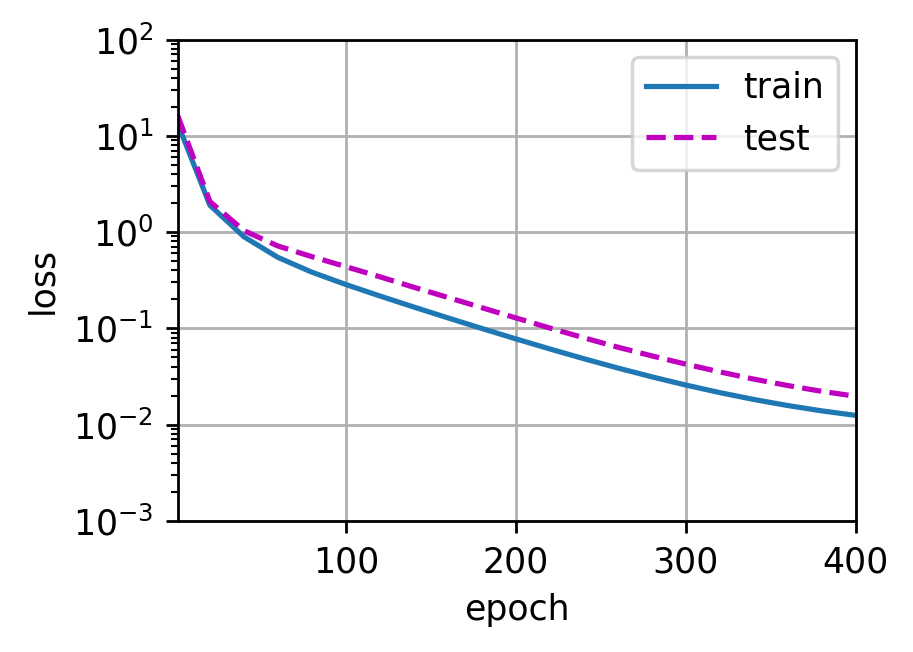

In [11]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.4280841 2.811586 ]]


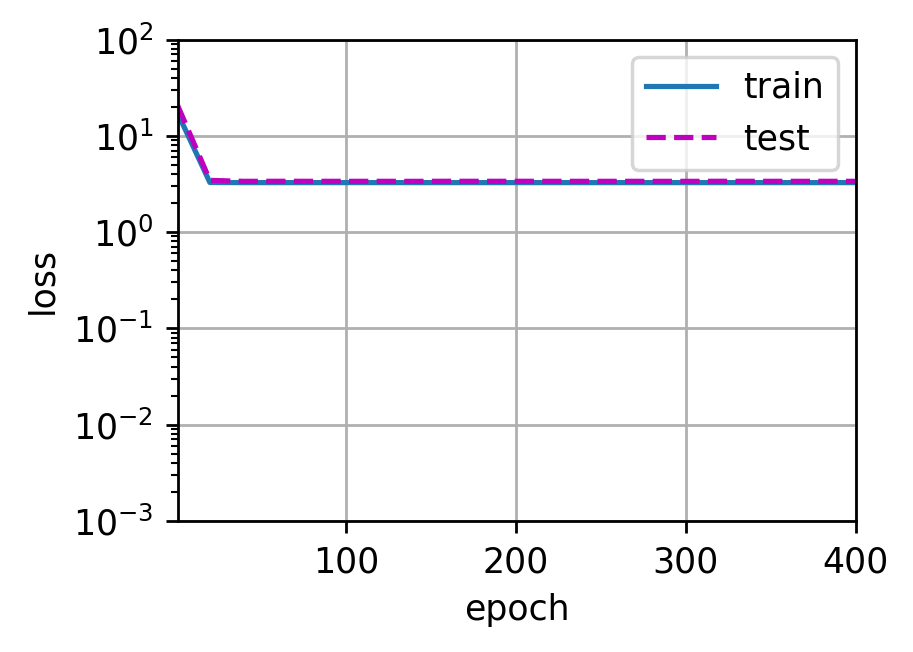

In [13]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9824142   1.2693931  -3.3207686   5.187945   -0.25820816  1.2515824
   0.00718938  0.17463557 -0.18186568  0.15408272  0.05584088  0.01993051
   0.17110412 -0.13874792 -0.0059379  -0.06772865  0.09863022  0.15003735
   0.02801678 -0.20958829]]


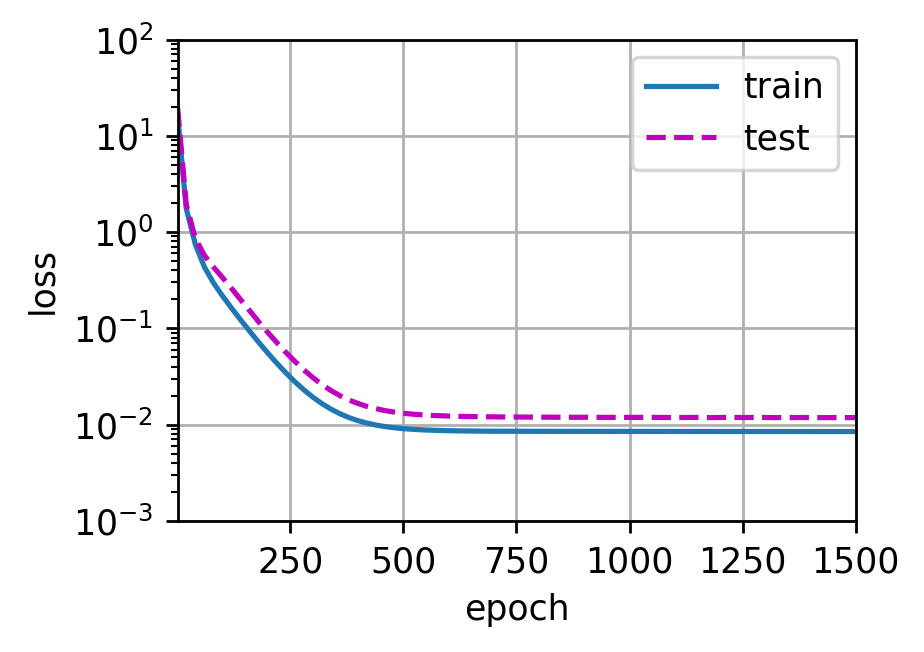

In [14]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)